## Simulate impermanent loss for Uniswap (V2)

Follows this article:

https://medium.com/gammaswap-labs/expected-impermanent-loss-in-uniswap-v2-v3-7fb81033bd81

In [1]:
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quantstats as qs
import warnings
FIGSIZE = (8,3)
SEED = 123
START_DATE = pd.to_datetime("2000-01-01")

def compute_performance_stats(prices):
    """
    Compute performance statistics for prices, converting to returns.

    Parameters
    ----------
    prices (np.array): array of size (N,)
    """
    daily_returns = pd.DataFrame(prices, columns=['price']).pct_change().dropna()
    # add date range
    dummy_date_range = [None] * len(daily_returns)
    dummy_date_range[0] = START_DATE
    for i in range(1, len(dummy_date_range)):
        dummy_date_range[i] = (dummy_date_range[i-1] + relativedelta(days=1))
    daily_returns.index = pd.DatetimeIndex(dummy_date_range)
    daily_returns = daily_returns.iloc[:,0] # series
    _ = daily_returns.plot(grid=True, figsize=(5,2))
    plt.show()
    print("""

==============================
PERFORMANCE STATISTICS

    """)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(qs.reports.metrics(daily_returns))


### Quick examples

#### Example: impermanent loss function

Two assets $x$ and $y$, constant AMM so that $xy=L^2$, and price of $y$ in terms of $x$ is given by $p = \frac{x}{y}$. ($x$ is the numeraire.)

$$
\textbf{IL}(k) = \frac{2\sqrt{k}}{1 + k} - 1
$$

for a price movement from $p \to kp$, $k>0$.

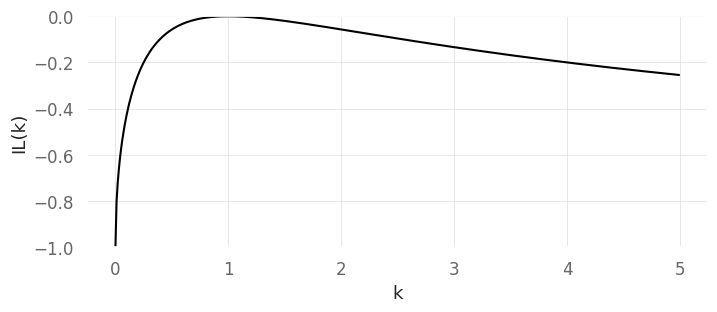

In [2]:
def il(k):
    return(
        (2 * np.sqrt(k)) / (1 + k) - 1
    )

x = np.arange(0, 5, 0.01) # don't use linspace!
y = [il(xi) for xi in x]
plt.figure(figsize=FIGSIZE)
plt.plot(x, y, color="black")
plt.xlabel("k")
plt.ylabel("IL(k)")
plt.ylim(-1, 0)
plt.grid(True)

In [3]:
# as expected

#### Example: Brownian motion

$$
dS_t = \mu dt + \sigma dB_t
$$

[ 0.         -0.00496628 -0.06487028 -0.08145829 -0.088059   -0.1024868
 -0.0845875  -0.07111193 -0.09048791 -0.12838049]


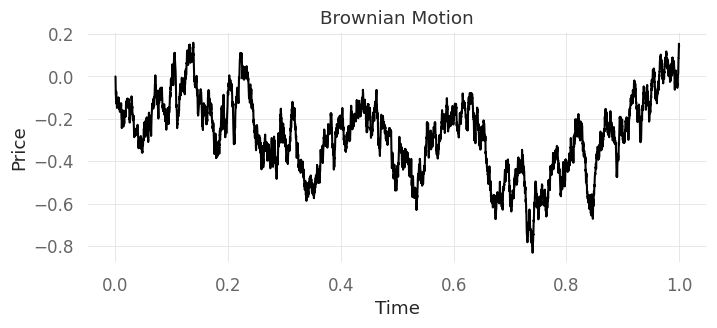

In [4]:
from stochastic.processes.continuous import BrownianMotion
from stochastic import random
random.seed(1331)
random.use_randomstate()

# Parameters
mu = 10 / 252                   # daily return (annualized / 252)
sigma = 20 / np.sqrt(252)       # daily vol (annualized / sqrt(252))
t = 1                          # time period
n = 252*20                     # number of time steps

# Simulate GBM
gbm = BrownianMotion(drift=mu, scale=sigma, t=t)
gbm_samples = gbm.sample(n) # inital value
print(gbm_samples[:10]) # starts at 1

# Plot
plt.figure(figsize=(8,3))
plt.plot(np.linspace(0, t, n+1), gbm_samples, color="black")
plt.title('Brownian Motion')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

#### Example: Geometric Brownian Motion

$$
d S_t = \mu S_t dt + \sigma S_t dB_t
$$

Used in Black-Scholes to model stock prices. Note this takes an initial value $S_0 \neq 0$ for the geometric motion. Remember $\mu, \sigma$ should converted to represent daily change in stock prices.

[1.         0.9945985  0.9941062  0.99481282 0.98722602 0.99719821
 0.99571119 1.0252167  1.05494692 1.02626556]


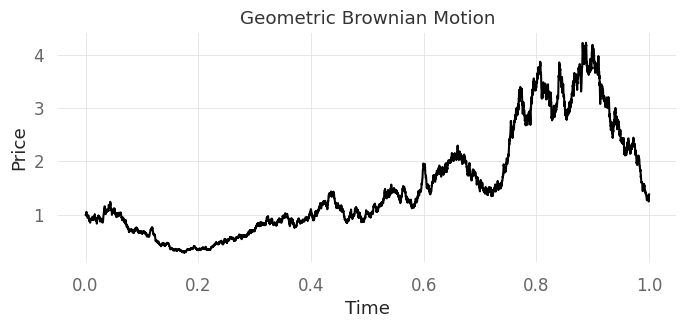

In [5]:
from stochastic.processes.continuous import GeometricBrownianMotion
from stochastic import random
random.seed(1441)
random.use_randomstate()

# Parameters
mu = 10 / 252                  # daily return (annualized: 10%)
sigma = 20 / np.sqrt(252)      # daily vol (annualized: 20%)
t = 1                          # time period: [1, T], represent the historical time interval
n = 252*20                     # number of time steps

# Simulate GBM
gbm = GeometricBrownianMotion(drift=mu, volatility=sigma, t=t)
gbm_samples = gbm.sample(n, initial=1) # inital value
print(gbm_samples[:10]) # starts at 1

# Plot
plt.figure(figsize=(8,3))
plt.plot(np.linspace(0, t, n+1), gbm_samples, color="black")
plt.title('Geometric Brownian Motion')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

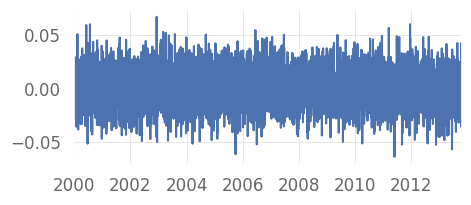



PERFORMANCE STATISTICS

    
                    Strategy
------------------  ----------
Start Period        2000-01-01
End Period          2013-10-18
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   38.64%
CAGR﹪              1.65%

Sharpe              0.2
Prob. Sharpe Ratio  81.33%
Sortino             0.29
Sortino/√2          0.2
Omega               1.03

Max Drawdown        -76.81%
Longest DD Days     1905

Gain/Pain Ratio     0.03
Gain/Pain (1M)      0.17

Payoff Ratio        1.03
Profit Factor       1.03
Common Sense Ratio  1.08
CPC Index           0.53
Tail Ratio          1.05
Outlier Win Ratio   2.91
Outlier Loss Ratio  2.97

MTD                 6.63%
3M                  -33.57%
6M                  -40.48%
YTD                 -50.84%
1Y                  -54.65%
3Y (ann.)           -16.11%
5Y (ann.)           -5.1%
10Y (ann.)          5.81%
All-time (ann.)     1.65%

Avg. Drawdown       -8.93%
Avg. Drawdown Days  85
Recovery Factor     1.46
Ulcer Index   

In [6]:
compute_performance_stats(gbm_samples)

### Simulate impermanent loss (Uniswap V2) in a liquidity pool

**Model**

Times $t = 1 \dots T$.

Consider a price change $p \to kp, k>0$. The impermanent loss (in-pool, vs. outside-pool) is given by:

$$
\begin{align}
    V &= x * p + y = 2 L \sqrt{pk} &\text{value, investing in liquidity pool} \\
    V_{\text{held}} &= x * p' + y = L \sqrt{p} (1 + k) &\text{value held, not invested in liquidity pool}
\end{align}
$$

**References**:

- https://medium.com/gammaswap-labs/total-returns-and-impermanent-loss-in-uniswap-v2-9f3d5b6ebc89
- https://medium.com/gammaswap-labs/expected-impermanent-loss-in-uniswap-v2-v3-7fb81033bd81